# Circular arena recognition

In this notebook, we train a resnet50-based CNN model on a set of open field video frames, to recognise an ellipse delimiting the arena where the animal/s are.

The dataset consists of 60000 images, 55000 of which are used for training, and 5000 for validation. In addition, data augmentation techniques are employed to improve generalization. We modify lighting conditions, flip and rotate the images on the fly using TensorFlow.

The notebook returns a trained model, that deepOF is capable of loading and using for predicting an ellipse in terms of five parameters: the x, y coordinates of the centers, the d and D length values of the major and minor axes, and an alpha value indicating the rotation in radians of the major axes with respect to the x axis of the image.

@author: lucasmiranda42

In [3]:
# Parameters for executing in the cloud using papermill

In [31]:
# imports and settings
import tensorflow as tf
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from tqdm.notebook import tqdm

### 1. Loading the data

In [7]:
vid_path = os.path.join("..", "..", "..", "Desktop", "deepof_circ_arena_dataset")

In [8]:
frames = [os.path.join(vid_path, i) for i in os.listdir(vid_path) if i.endswith(".jpg")]
print("Extracted {} images from deepof videos".format(len(frames)))

Extracted 62250 images from deepof videos


In [14]:
# res_frames = np.array([cv2.resize(cv2.imread(i), (224,224)) for i in tqdm(frames)])
# print(res_frames.shape)


(62250, 224, 224, 3)


In [9]:
#Save np.ndarray to avoid reruning above cells
#np.save(os.path.join(vid_path, "circ_arena_dataset.npy"), res_frames)

In [11]:
#Comment cells above and load data in numpy format to avoid recomputing
res_frames = np.load(os.path.join(vid_path, "circ_arena_dataset.npy"))
print(res_frames.shape)

(62250, 224, 224, 3)


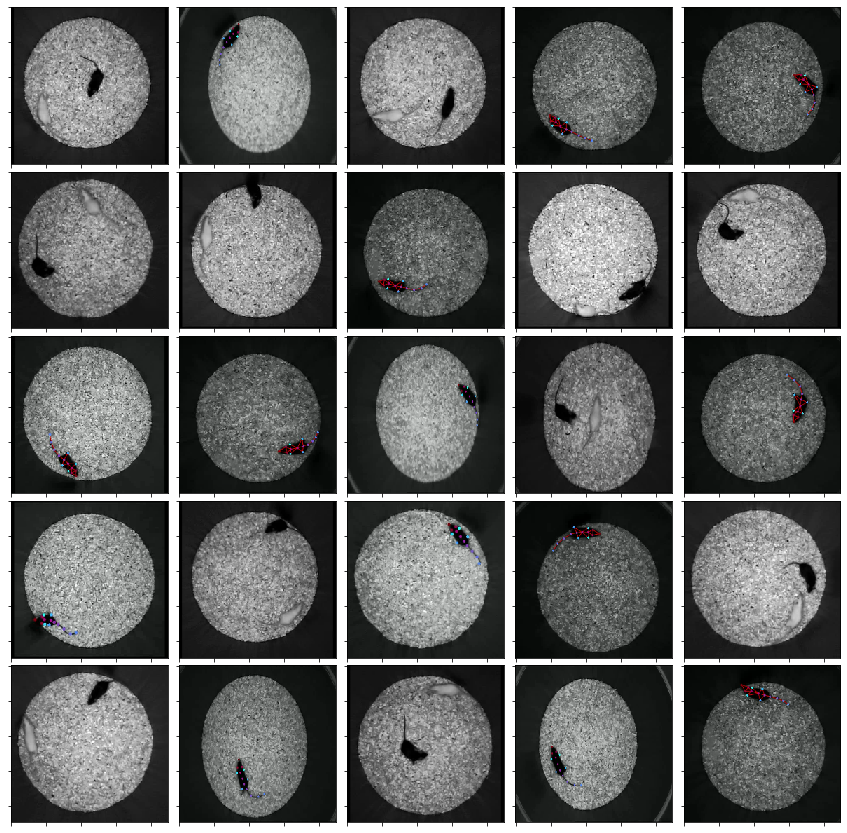

In [36]:
# Display random images
plt.figure(figsize=(15, 15))
gs1 = gridspec.GridSpec(5, 5)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(25):

    ax1 = plt.subplot(gs1[i])
    plt.axis("on")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect("equal")
    ax1.imshow(res_frames[np.random.randint(0, res_frames.shape[0])])

plt.show()

### 2. Get ellipse labels

In [188]:
# Define a custom version of deepof.utils.circular_arena_recognition
def circular_arena_recognition(frame: np.array) -> np.array:
    """Returns x,y position of the center, the lengths of the major and minor axes, 
    and the angle of the recognised arena

    Parameters:
        - frame (np.array): numpy.array representing an individual frame of a video

    Returns:
        - circles (np.array): 3-element-array containing x,y positions of the center
        of the arena, and a third value indicating the radius"""

    # Convert image to greyscale, threshold it, blur it and apply open-close operations
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray_image, 255//5, 255, 0)

    # Find contours in the processed image
    cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    main_cnt = np.argmax([len(c) for c in cnts])

    # Detect the main ellipse containing the arena
    ellipse_params = cv2.fitEllipse(cnts[main_cnt])
    center_x, center_y = tuple([int(i) for i in ellipse_params[0]])
    axes_L, axes_l = tuple([int(i) // 2 for i in ellipse_params[1]])
    ellipse_angle = ellipse_params[2]

    return int(center_x), int(center_y), int(axes_L), int(axes_l), ellipse_angle

51


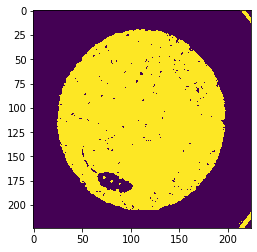

In [189]:
test = res_frames[4]
gray_image = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray_image, 51, 255, 0)
cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
main_cnt = np.argmax([len(c) for c in cnts])

plt.imshow(thresh)
print(255//5)

In [ ]:
ellipse_labels = np.array([circular_arena_recognition(frame) for frame in tqdm(res_frames)])
print(ellipse_labels.shape)

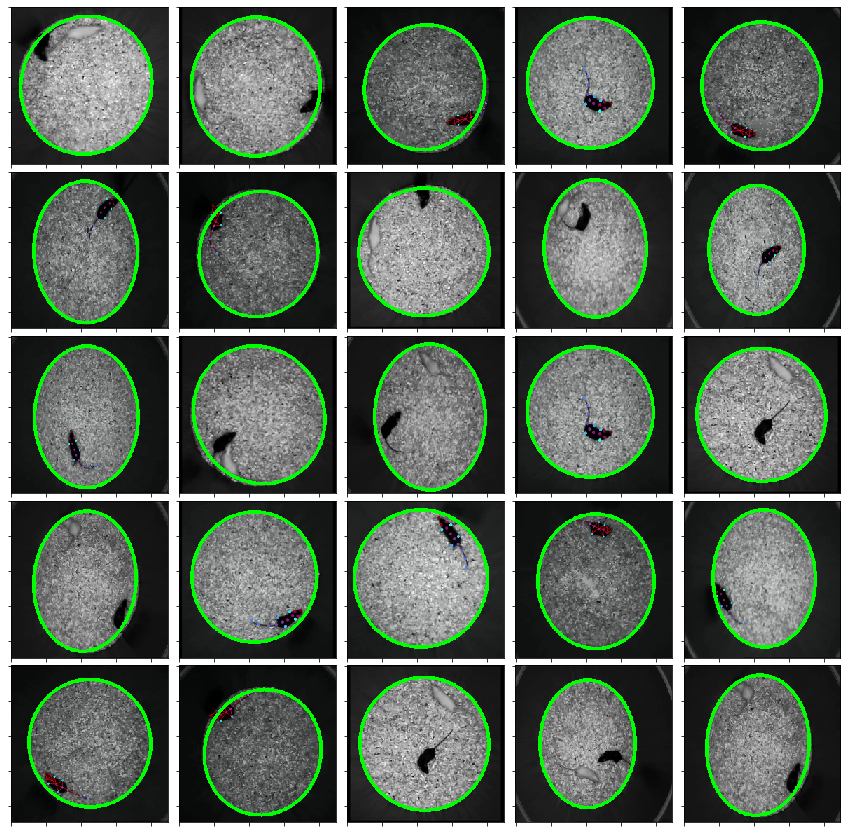

In [191]:
# Display random images with ellipses on top
plt.figure(figsize=(15, 15))
gs1 = gridspec.GridSpec(5, 5)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(25):

    temp_image = res_frames[i].copy()
    temp_ellipse = ellipse_labels[i]

    ax1 = plt.subplot(gs1[i])
    plt.axis("on")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect("equal")
    cv2.ellipse(
        temp_image,
        tuple(temp_ellipse[:2].astype(int)),
        tuple(temp_ellipse[2:4].astype(int)),
        temp_ellipse[4],
        0,
        360,
        (0, 255, 0),
        3,
    )
    ax1.imshow(temp_image)

plt.show()

### 3. Generate tf.Data.dataset objects for training and validation

### 4. Data augmentation

### 5. Model definition

### 6. Model training

### 7. Model evaluation